# Exploratory Analysis of TDA Results

## Load packages.

In [1]:
require(data.table)
#require(dplyr)
#require(e1071)
require(glmulti)
require(magrittr)
require(MASS)
require(randomForest)
require(rpart)
require(validann)

require(ggplot2)
require(GGally)

Loading required package: data.table
Loading required package: glmulti
Loading required package: rJava
Loading required package: magrittr
Loading required package: MASS
Loading required package: randomForest
randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.
Loading required package: rpart
Loading required package: validann
Loading required package: ggplot2

Attaching package: 'ggplot2'

The following object is masked from 'package:randomForest':

    margin

Loading required package: GGally
Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


## Prepare data.

### Read data.

In [31]:
z.raw <- NULL
for (i in c("00", "01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12", "13", "14", "15",
            "16", "17", "18", "19", "20", "21", "22", "23", "24", "25", "26", "27", "28", "29", "30", "31",
            "32", "33", "34", "35", "36", "37", "38"))
    z.raw <- rbind(z.raw, fread(paste(i, "Line-results.tsv", sep="/")))
z.raw[, `Unserved?` := `Unserved MW` > 0]
z.raw %>% dim

[1] 850468     23

In [32]:
z.raw %>% summary

      Case            Outage Count   Outage Fraction      Outages         
 Min.   :100000000   Min.   : 0.00   Min.   :0.000000   Length:850468     
 1st Qu.:111011438   1st Qu.: 6.00   1st Qu.:0.002559   Class :character  
 Median :122004208   Median :12.00   Median :0.005117   Mode  :character  
 Mean   :121056749   Mean   :12.14   Mean   :0.005177                     
 3rd Qu.:132004699   3rd Qu.:17.00   3rd Qu.:0.007249                     
 Max.   :138031090   Max.   :32.00   Max.   :0.013646                     
                                                                          
   Served MW      Unserved MW       Unserved Fraction Reactance Loss pu
 Min.   :65647   Min.   :   0.000   Min.   :0.0000    Min.   :0.0000   
 1st Qu.:67109   1st Qu.:   0.000   1st Qu.:0.0000    1st Qu.:0.2242   
 Median :67109   Median :   0.000   Median :0.0000    Median :0.4491   
 Mean   :67107   Mean   :   1.978   Mean   :0.0000    Mean   :0.4874   
 3rd Qu.:67109   3rd Qu.:   0.000   3rd 

### Clean up data.

In [33]:
z <- z.raw[!is.na(`Unserved MW`)]
colnames(z) <- c(
    'Case',
    'Outage_Count', 'Outage_Fraction', 'Outages',
    'Served_MW', 'Unserved_MW', 'Unserved_Fraction',
    'Reactance_Loss_pu', 'Reactance_Betti_0', 'Reactance_Betti_1', 'Reactance_Bottleneck_0', 'Reactance_Bottleneck_1',
    'Capacity_Loss_MW', 'Capacity_Betti_0', 'Capacity_Betti_1', 'Capacity_Bottleneck_0', 'Capacity_Bottleneck_1',
    'Base_Flow_Loss_MW', 'Base_Flow_Betti_0', 'Base_Flow_Betti_1', 'Base_Flow_Bottleneck_0', 'Base_Flow_Bottleneck_1',
    'Has_Unserved'
)

In [34]:
z.clean <- z
z.clean[, Reactance_Bottleneck_0_Infinite := is.infinite(Reactance_Bottleneck_0)]
z.clean[, Reactance_Bottleneck_1_Infinite := is.infinite(Reactance_Bottleneck_1)]
z.clean[, Capacity_Bottleneck_0_Infinite  := is.infinite(Capacity_Bottleneck_0 )]
z.clean[, Capacity_Bottleneck_1_Infinite  := is.infinite(Capacity_Bottleneck_1 )]
z.clean[, Base_Flow_Bottleneck_0_Infinite := is.infinite(Base_Flow_Bottleneck_0)]
z.clean[, Base_Flow_Bottleneck_1_Infinite := is.infinite(Base_Flow_Bottleneck_1)]
z.clean[Reactance_Bottleneck_0 == TRUE, Reactance_Bottleneck_0 := NA]
z.clean[Reactance_Bottleneck_1 == TRUE, Reactance_Bottleneck_1 := NA]
z.clean[Capacity_Bottleneck_0  == TRUE, Capacity_Bottleneck_0  := NA]
z.clean[Capacity_Bottleneck_1  == TRUE, Capacity_Bottleneck_1  := NA]
z.clean[Base_Flow_Bottleneck_0 == TRUE, Base_Flow_Bottleneck_0 := NA]
z.clean[Base_Flow_Bottleneck_1 == TRUE, Base_Flow_Bottleneck_1 := NA]

## Descriptive graphics.

### System measurements.

#### Distribution of unserved load.

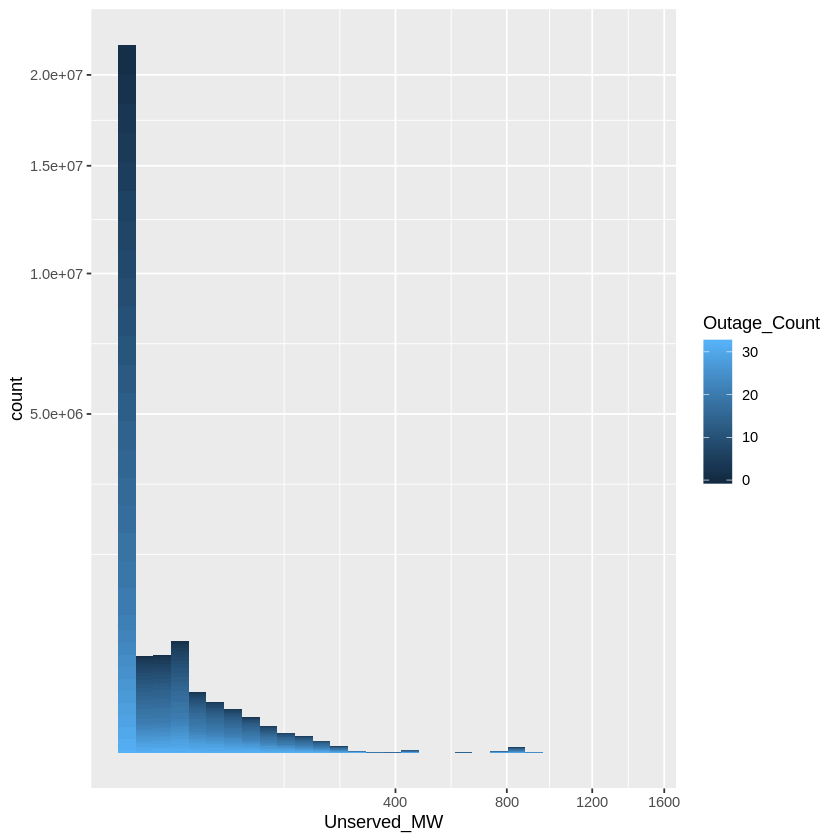

In [99]:
ggplot(z.clean, aes(x = Unserved_MW, group = Outage_Count, fill = Outage_Count)) +
    geom_histogram(bins = 30) +
    scale_x_sqrt() +
    scale_y_sqrt()

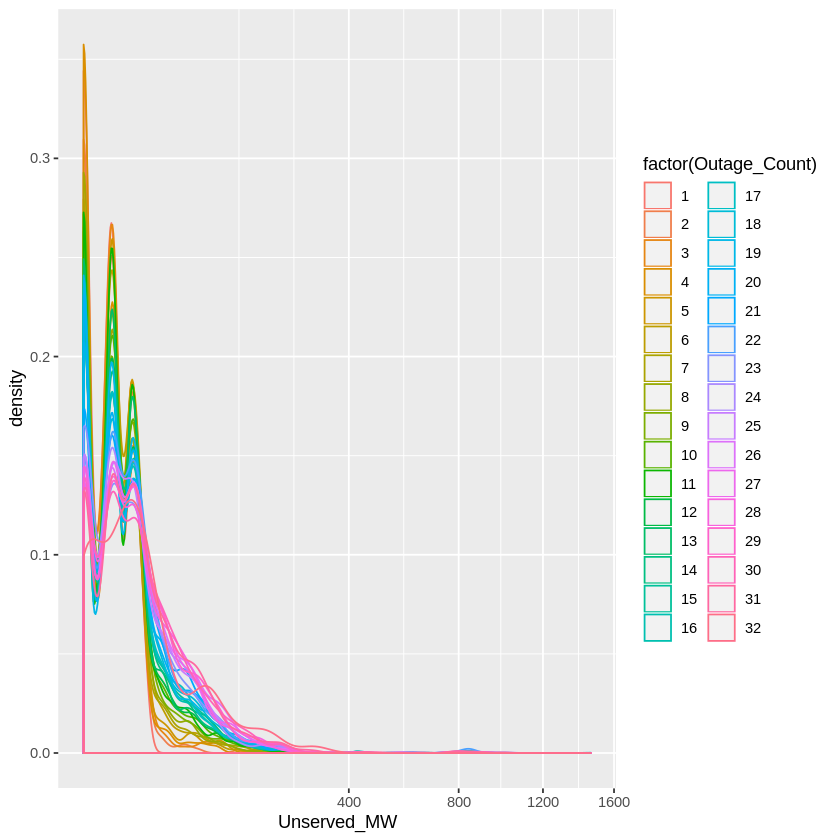

In [58]:
ggplot(z.clean[Unserved_MW > 0], aes(x = Unserved_MW, group=factor(Outage_Count), color=factor(Outage_Count))) +
    geom_density() +
    scale_x_sqrt()

#### Unserved load as a function of capacity lost.

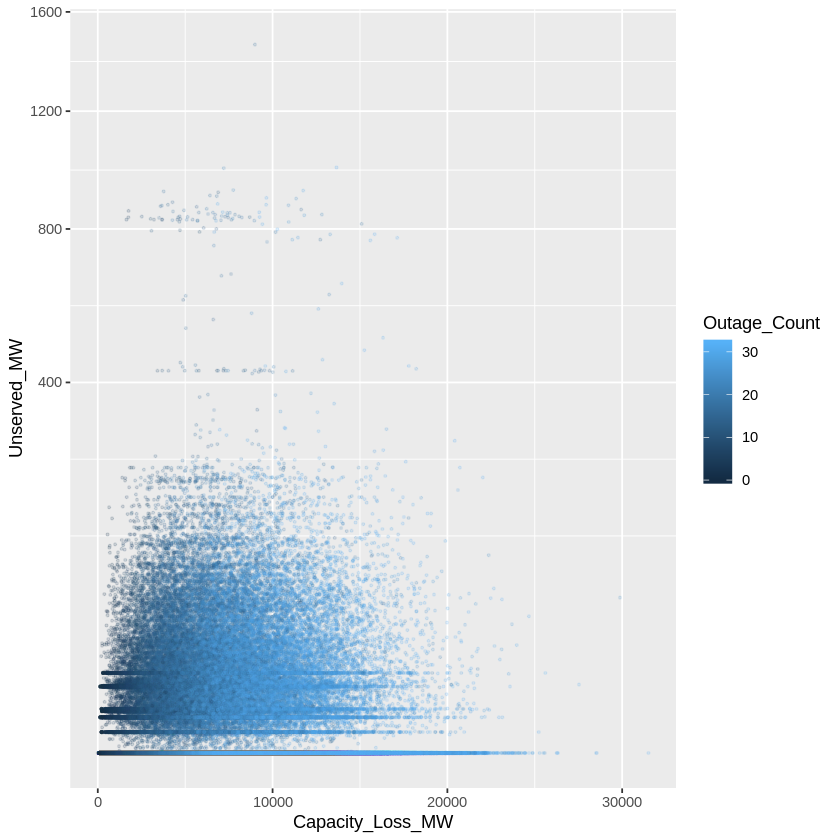

In [97]:
ggplot(
    z.clean,
    aes(x = Capacity_Loss_MW, y = Unserved_MW, color = Outage_Count)
) +
    geom_point(size=0.5, alpha=0.15) +
    scale_y_sqrt()

### Topology measurements.

#### Betti numbers.

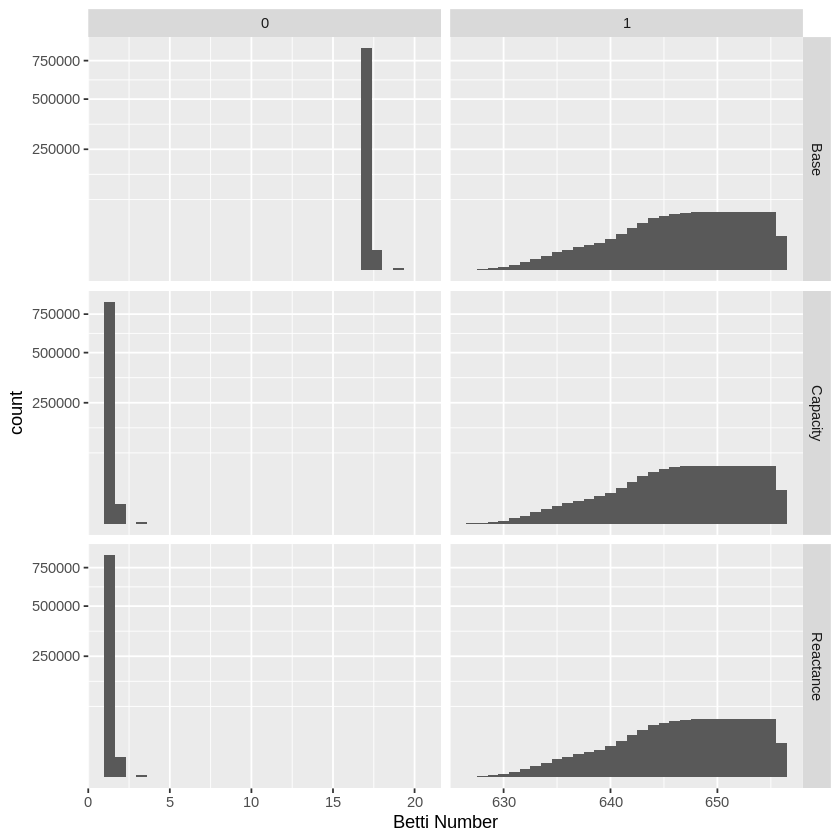

In [86]:
ggplot(
    melt(
        z,
        id.vars = "Case",
        measure.vars=c(
            "Reactance_Betti_0", "Reactance_Betti_1",
            "Capacity_Betti_0" , "Capacity_Betti_1" ,
            "Base_Flow_Betti_0", "Base_Flow_Betti_1"
        ),
        variable.name = "Metric",
        value.name = "Betti Number"
    )[, .(
        Case,
        Weight = sub("_.*$", "", Metric),
        Dimension = sub("^.*_", "", Metric),
        `Betti Number`
    )],
    aes(x = `Betti Number`)
) + 
    geom_histogram(bins = 30) +
    scale_y_sqrt() +
    facet_grid(Weight ~ Dimension, scales = "free_x")

#### Bottleneck distances.

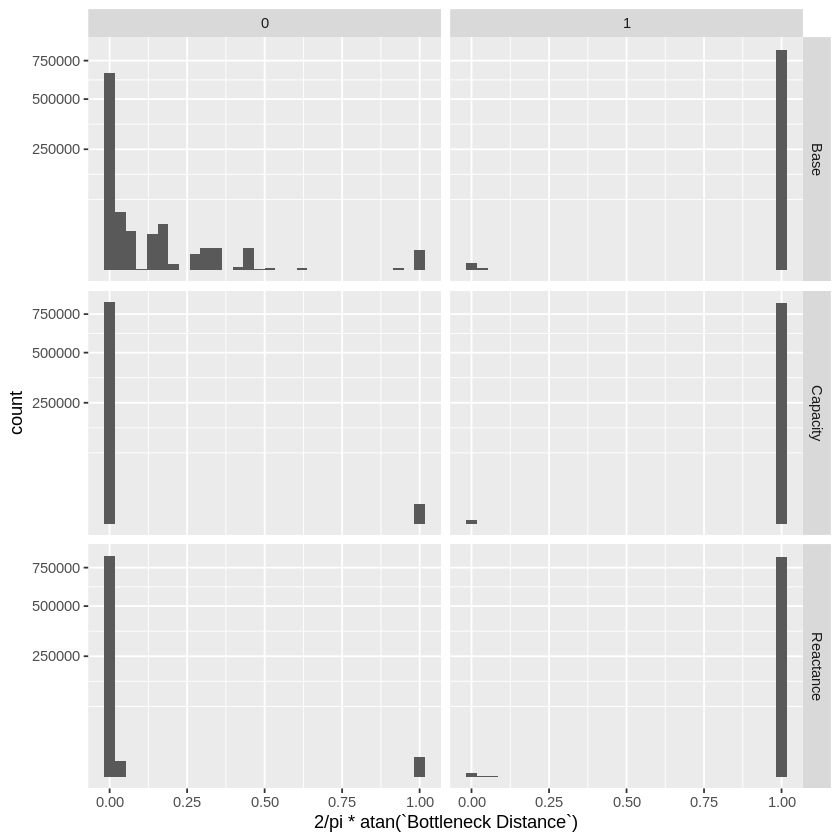

In [85]:
ggplot(
    melt(
        z,
        id.vars = "Case",
        measure.vars=c(
            "Reactance_Bottleneck_0", "Reactance_Bottleneck_1",
            "Capacity_Bottleneck_0" , "Capacity_Bottleneck_1" ,
            "Base_Flow_Bottleneck_0", "Base_Flow_Bottleneck_1"
        ),
        variable.name = "Metric",
        value.name = "Bottleneck Distance"
    )[, .(
        Case,
        Weight = sub("_.*$", "", Metric),
        Dimension = sub("^.*_", "", Metric),
        `Bottleneck Distance`
    )][`Bottleneck Distance` > 0],
    aes(x = 2 / pi * atan(`Bottleneck Distance`))
) + 
    geom_histogram(bins = 30) +
    scale_y_sqrt() +
    facet_grid(Weight ~ Dimension, scales = "free_x")

### Pairs plot.

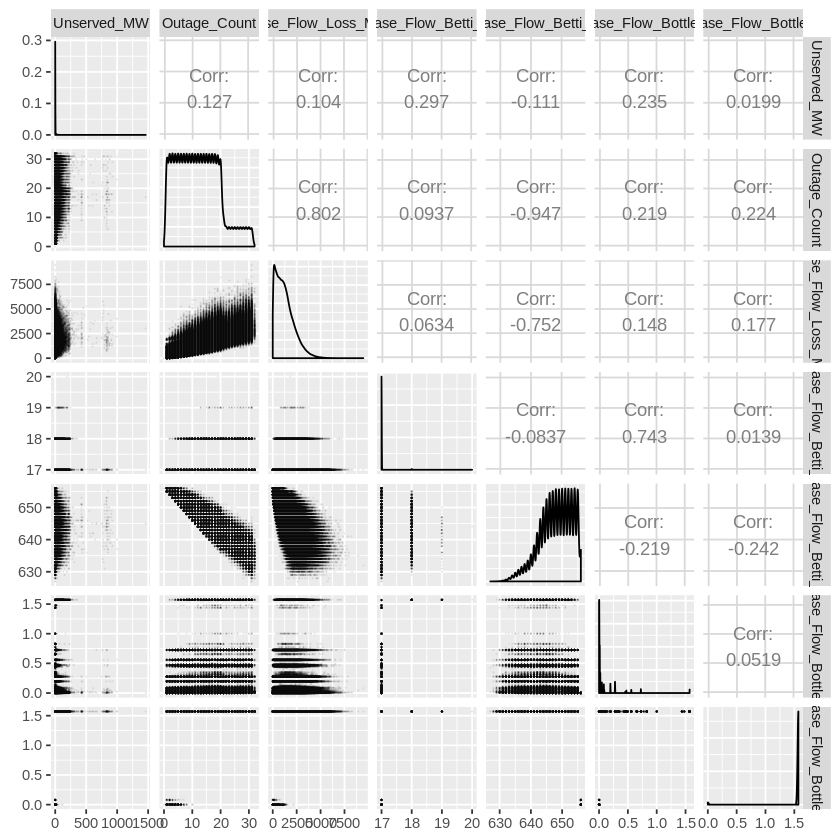

In [173]:
ggpairs(
    z[, .(
        Unserved_MW,
        Outage_Count,
        Base_Flow_Loss_MW,
        Base_Flow_Betti_0,
        Base_Flow_Betti_1,
        atan_Base_Flow_Bottleneck_0 = atan(Base_Flow_Bottleneck_0),
        atan_Base_Flow_Bottleneck_1 = atan(Base_Flow_Bottleneck_1)
    )],
    1:7,
    lower = list(continuous = wrap("points", alpha = 0.05, size = 0.03))
)

## Simple CART.

### Classification tree.

#### Topology measures only.

In [126]:
z.rpart <- rpart(
    Has_Unserved ~
#       Outage_Fraction +
#       Reactance_Loss_pu +
        Reactance_Betti_0 + Reactance_Betti_1 + atan_Reactance_Bottleneck_0 + atan_Reactance_Bottleneck_1 +
#       Capacity_Loss MW  +
        Capacity_Betti_0  + Capacity_Betti_1  + atan_Capacity_Bottleneck_0  + atan_Capacity_Bottleneck_1  +
#       Base_Flow Loss_MW +
        Base_Flow_Betti_0 + Base_Flow_Betti_1 + atan_Base_Flow_Bottleneck_0 + atan_Base_Flow_Bottleneck_1 ,
    data = z.clean[, .(
        Has_Unserved,
        Reactance_Loss_pu,
        Reactance_Betti_0,
        Reactance_Betti_1,
        atan_Reactance_Bottleneck_0 = atan(Reactance_Bottleneck_0),
        atan_Reactance_Bottleneck_1 = atan(Reactance_Bottleneck_1),
        Capacity_Loss_MW,
        Capacity_Betti_0,
        Capacity_Betti_1,
        atan_Capacity_Bottleneck_0 = atan(Capacity_Bottleneck_0),
        atan_Capacity_Bottleneck_1 = atan(Capacity_Bottleneck_1),
        Base_Flow_Loss_MW,
        Base_Flow_Betti_0,
        Base_Flow_Betti_1,
        atan_Base_Flow_Bottleneck_0 = atan(Base_Flow_Bottleneck_0),
        atan_Base_Flow_Bottleneck_1 = atan(Base_Flow_Bottleneck_1)
    )],
    control = rpart.control(cp = 0.0025)
)
z.rpart

n= 848772 

node), split, n, deviance, yval
      * denotes terminal node

 1) root 848772 80606.4700 0.10625940  
   2) atan_Capacity_Bottleneck_0< 0.7859476 841776 75480.8200 0.09958588  
     4) Reactance_Betti_1>=647.5 477768 24045.1700 0.05315341  
       8) Reactance_Betti_1>=651.5 249261  6819.4630 0.02815121 *
       9) Reactance_Betti_1< 651.5 228507 16899.9200 0.08042642 *
     5) Reactance_Betti_1< 647.5 364008 49053.6200 0.16052940  
      10) atan_Capacity_Bottleneck_0< 0.0003629435 225943 27078.1100 0.13922980 *
      11) atan_Capacity_Bottleneck_0>=0.0003629435 138065 21705.2600 0.19538620 *
   3) atan_Capacity_Bottleneck_0>=0.7859476 6996   577.3635 0.90923380 *

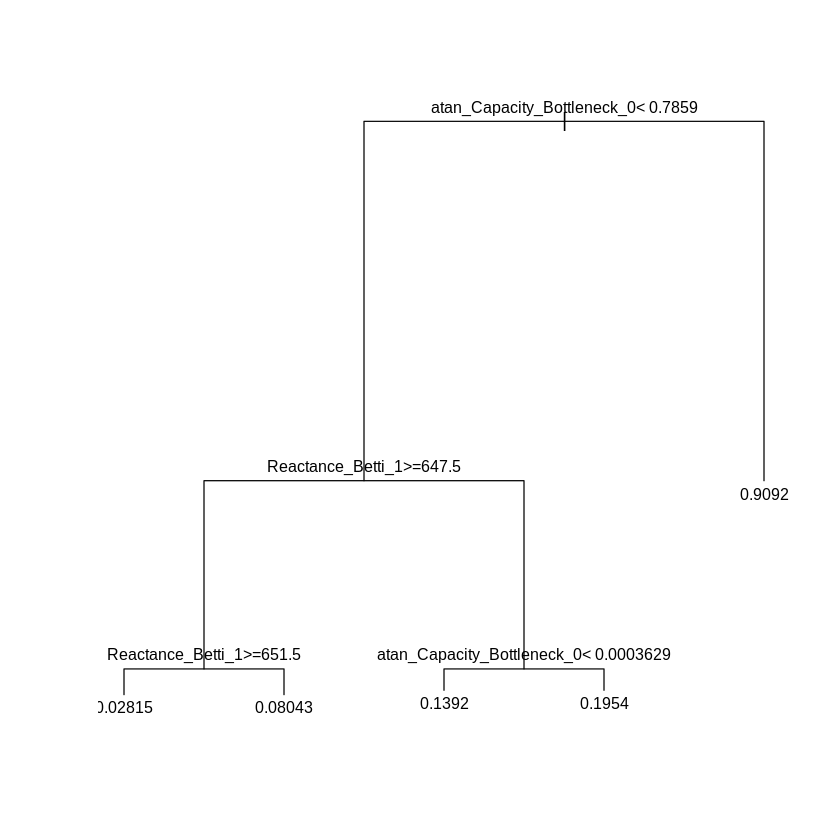

In [127]:
plot(z.rpart)
text(z.rpart, cex=0.8)

#### System and topology measures.

In [119]:
z.rpart <- rpart(
    Has_Unserved ~
#       Outage_Fraction +
        Reactance_Loss_pu +
        Reactance_Betti_0 + Reactance_Betti_1 + atan_Reactance_Bottleneck_0 + atan_Reactance_Bottleneck_1 +
        Capacity_Loss_MW  +
        Capacity_Betti_0  + Capacity_Betti_1  + atan_Capacity_Bottleneck_0  + atan_Capacity_Bottleneck_1  +
        Base_Flow_Loss_MW +
        Base_Flow_Betti_0 + Base_Flow_Betti_1 + atan_Base_Flow_Bottleneck_0 + atan_Base_Flow_Bottleneck_1 ,
    data = z.clean[, .(
        Has_Unserved,
        Reactance_Loss_pu,
        Reactance_Betti_0,
        Reactance_Betti_1,
        atan_Reactance_Bottleneck_0 = atan(Reactance_Bottleneck_0),
        atan_Reactance_Bottleneck_1 = atan(Reactance_Bottleneck_1),
        Capacity_Loss_MW,
        Capacity_Betti_0,
        Capacity_Betti_1,
        atan_Capacity_Bottleneck_0 = atan(Capacity_Bottleneck_0),
        atan_Capacity_Bottleneck_1 = atan(Capacity_Bottleneck_1),
        Base_Flow_Loss_MW,
        Base_Flow_Betti_0,
        Base_Flow_Betti_1,
        atan_Base_Flow_Bottleneck_0 = atan(Base_Flow_Bottleneck_0),
        atan_Base_Flow_Bottleneck_1 = atan(Base_Flow_Bottleneck_1)
    )],
    control = rpart.control(cp = 0.0025)
)
z.rpart

n= 848772 

node), split, n, deviance, yval
      * denotes terminal node

 1) root 848772 80606.4700 0.10625940  
   2) atan_Capacity_Bottleneck_0< 0.7859476 841776 75480.8200 0.09958588  
     4) Reactance_Betti_1>=647.5 477768 24045.1700 0.05315341  
       8) Base_Flow_Loss_MW< 597.1377 237564  5724.0070 0.02470492 *
       9) Base_Flow_Loss_MW>=597.1377 240204 17938.7500 0.08128924 *
     5) Reactance_Betti_1< 647.5 364008 49053.6200 0.16052940  
      10) atan_Capacity_Bottleneck_0< 0.0003629435 225943 27078.1100 0.13922980  
        20) Base_Flow_Loss_MW< 2198.679 156880 16424.4900 0.11881060 *
        21) Base_Flow_Loss_MW>=2198.679 69063 10439.6300 0.18561310 *
      11) atan_Capacity_Bottleneck_0>=0.0003629435 138065 21705.2600 0.19538620 *
   3) atan_Capacity_Bottleneck_0>=0.7859476 6996   577.3635 0.90923380 *

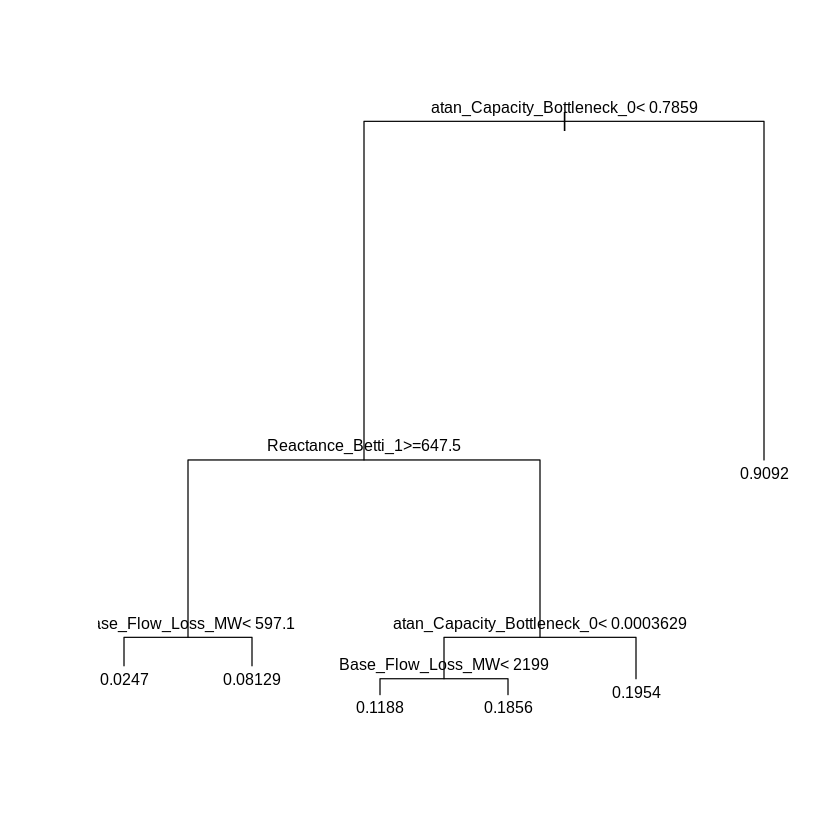

In [125]:
plot(z.rpart)
text(z.rpart, cex=0.8)

### Regression tree.

#### Topology measures only.

In [129]:
z.rpart <- rpart(
    Unserved_MW ~
#       Outage_Fraction +
#       Reactance_Loss_pu +
        Reactance_Betti_0 + Reactance_Betti_1 + atan_Reactance_Bottleneck_0 + atan_Reactance_Bottleneck_1 +
#       Capacity_Loss MW  +
        Capacity_Betti_0  + Capacity_Betti_1  + atan_Capacity_Bottleneck_0  + atan_Capacity_Bottleneck_1  +
#       Base_Flow Loss_MW +
        Base_Flow_Betti_0 + Base_Flow_Betti_1 + atan_Base_Flow_Bottleneck_0 + atan_Base_Flow_Bottleneck_1 ,
    data = z.clean[, .(
        Unserved_MW,
        Reactance_Loss_pu,
        Reactance_Betti_0,
        Reactance_Betti_1,
        atan_Reactance_Bottleneck_0 = atan(Reactance_Bottleneck_0),
        atan_Reactance_Bottleneck_1 = atan(Reactance_Bottleneck_1),
        Capacity_Loss_MW,
        Capacity_Betti_0,
        Capacity_Betti_1,
        atan_Capacity_Bottleneck_0 = atan(Capacity_Bottleneck_0),
        atan_Capacity_Bottleneck_1 = atan(Capacity_Bottleneck_1),
        Base_Flow_Loss_MW,
        Base_Flow_Betti_0,
        Base_Flow_Betti_1,
        atan_Base_Flow_Bottleneck_0 = atan(Base_Flow_Bottleneck_0),
        atan_Base_Flow_Bottleneck_1 = atan(Base_Flow_Bottleneck_1)
    )],
    method = "anova",
    control = rpart.control(cp = 0.0025)
)
z.rpart

n= 848772 

node), split, n, deviance, yval
      * denotes terminal node

1) root 848772 181707600  1.9783770  
  2) atan_Capacity_Bottleneck_0< 0.7859476 841776 151431600  1.5837460  
    4) Reactance_Betti_1>=646.5 533384  43568800  0.7887536 *
    5) Reactance_Betti_1< 646.5 308392 106942600  2.9587380 *
  3) atan_Capacity_Bottleneck_0>=0.7859476 6996  14371580 49.4613000 *

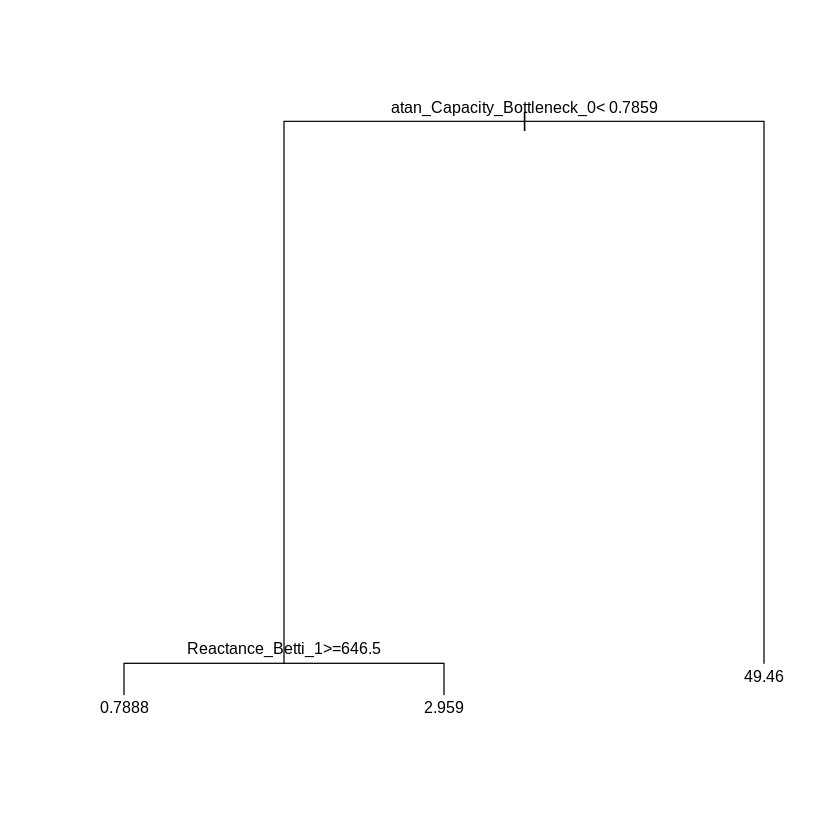

In [130]:
plot(z.rpart)
text(z.rpart, cex=0.8)

#### System and topology measures.

In [131]:
z.rpart <- rpart(
    Unserved_MW ~
#       Outage_Fraction +
        Reactance_Loss_pu +
        Reactance_Betti_0 + Reactance_Betti_1 + atan_Reactance_Bottleneck_0 + atan_Reactance_Bottleneck_1 +
        Capacity_Loss_MW  +
        Capacity_Betti_0  + Capacity_Betti_1  + atan_Capacity_Bottleneck_0  + atan_Capacity_Bottleneck_1  +
        Base_Flow_Loss_MW +
        Base_Flow_Betti_0 + Base_Flow_Betti_1 + atan_Base_Flow_Bottleneck_0 + atan_Base_Flow_Bottleneck_1 ,
    data = z.clean[, .(
        Unserved_MW,
        Reactance_Loss_pu,
        Reactance_Betti_0,
        Reactance_Betti_1,
        atan_Reactance_Bottleneck_0 = atan(Reactance_Bottleneck_0),
        atan_Reactance_Bottleneck_1 = atan(Reactance_Bottleneck_1),
        Capacity_Loss_MW,
        Capacity_Betti_0,
        Capacity_Betti_1,
        atan_Capacity_Bottleneck_0 = atan(Capacity_Bottleneck_0),
        atan_Capacity_Bottleneck_1 = atan(Capacity_Bottleneck_1),
        Base_Flow_Loss_MW,
        Base_Flow_Betti_0,
        Base_Flow_Betti_1,
        atan_Base_Flow_Bottleneck_0 = atan(Base_Flow_Bottleneck_0),
        atan_Base_Flow_Bottleneck_1 = atan(Base_Flow_Bottleneck_1)
    )],
    method = "anova",
    control = rpart.control(cp = 0.0025)
)
z.rpart

n= 848772 

node), split, n, deviance, yval
      * denotes terminal node

1) root 848772 181707600  1.9783770  
  2) atan_Capacity_Bottleneck_0< 0.7859476 841776 151431600  1.5837460  
    4) Base_Flow_Loss_MW< 1270.46 482864  22251940  0.6651538 *
    5) Base_Flow_Loss_MW>=1270.46 358912 128224100  2.8195790 *
  3) atan_Capacity_Bottleneck_0>=0.7859476 6996  14371580 49.4613000 *

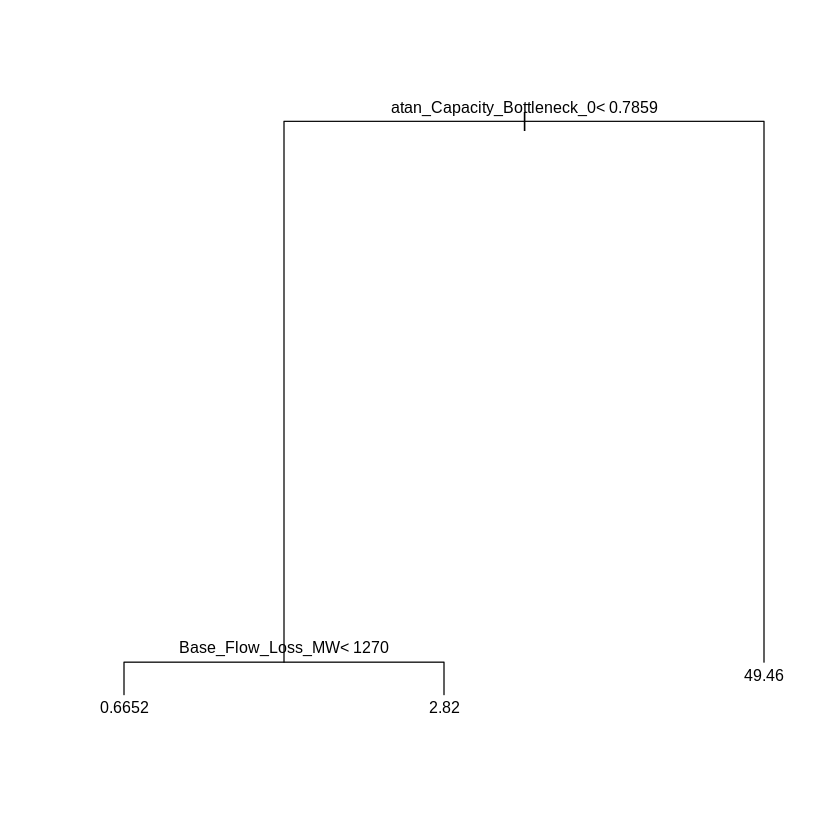

In [132]:
plot(z.rpart)
text(z.rpart, cex=0.8)

## Support vector machine.

## Linear model.

In [133]:
z.model <- lm(
    Unserved_MW ~
#       Outage_Fraction +
        Reactance_Loss_pu +
        Reactance_Betti_0 + Reactance_Betti_1 + atan_Reactance_Bottleneck_0 + atan_Reactance_Bottleneck_1 +
        Capacity_Loss_MW  +
        Capacity_Betti_0  + Capacity_Betti_1  + atan_Capacity_Bottleneck_0  + atan_Capacity_Bottleneck_1  +
        Base_Flow_Loss_MW +
        Base_Flow_Betti_0 + Base_Flow_Betti_1 + atan_Base_Flow_Bottleneck_0 + atan_Base_Flow_Bottleneck_1 ,
    data = z.clean[, .(
        Unserved_MW,
        Reactance_Loss_pu,
        Reactance_Betti_0,
        Reactance_Betti_1,
        atan_Reactance_Bottleneck_0 = atan(Reactance_Bottleneck_0),
        atan_Reactance_Bottleneck_1 = atan(Reactance_Bottleneck_1),
        Capacity_Loss_MW,
        Capacity_Betti_0,
        Capacity_Betti_1,
        atan_Capacity_Bottleneck_0 = atan(Capacity_Bottleneck_0),
        atan_Capacity_Bottleneck_1 = atan(Capacity_Bottleneck_1),
        Base_Flow_Loss_MW,
        Base_Flow_Betti_0,
        Base_Flow_Betti_1,
        atan_Base_Flow_Bottleneck_0 = atan(Base_Flow_Bottleneck_0),
        atan_Base_Flow_Bottleneck_1 = atan(Base_Flow_Bottleneck_1)
    )]
)
z.model


Call:
lm(formula = Unserved_MW ~ Reactance_Loss_pu + Reactance_Betti_0 + 
    Reactance_Betti_1 + atan_Reactance_Bottleneck_0 + atan_Reactance_Bottleneck_1 + 
    Capacity_Loss_MW + Capacity_Betti_0 + Capacity_Betti_1 + 
    atan_Capacity_Bottleneck_0 + atan_Capacity_Bottleneck_1 + 
    Base_Flow_Loss_MW + Base_Flow_Betti_0 + Base_Flow_Betti_1 + 
    atan_Base_Flow_Bottleneck_0 + atan_Base_Flow_Bottleneck_1, 
    data = z.clean[, .(Unserved_MW, Reactance_Loss_pu, Reactance_Betti_0, 
        Reactance_Betti_1, atan_Reactance_Bottleneck_0 = atan(Reactance_Bottleneck_0), 
        atan_Reactance_Bottleneck_1 = atan(Reactance_Bottleneck_1), 
        Capacity_Loss_MW, Capacity_Betti_0, Capacity_Betti_1, 
        atan_Capacity_Bottleneck_0 = atan(Capacity_Bottleneck_0), 
        atan_Capacity_Bottleneck_1 = atan(Capacity_Bottleneck_1), 
        Base_Flow_Loss_MW, Base_Flow_Betti_0, Base_Flow_Betti_1, 
        atan_Base_Flow_Bottleneck_0 = atan(Base_Flow_Bottleneck_0), 
        atan_Base_Flow

In [134]:
z.model %>% summary


Call:
lm(formula = Unserved_MW ~ Reactance_Loss_pu + Reactance_Betti_0 + 
    Reactance_Betti_1 + atan_Reactance_Bottleneck_0 + atan_Reactance_Bottleneck_1 + 
    Capacity_Loss_MW + Capacity_Betti_0 + Capacity_Betti_1 + 
    atan_Capacity_Bottleneck_0 + atan_Capacity_Bottleneck_1 + 
    Base_Flow_Loss_MW + Base_Flow_Betti_0 + Base_Flow_Betti_1 + 
    atan_Base_Flow_Bottleneck_0 + atan_Base_Flow_Bottleneck_1, 
    data = z.clean[, .(Unserved_MW, Reactance_Loss_pu, Reactance_Betti_0, 
        Reactance_Betti_1, atan_Reactance_Bottleneck_0 = atan(Reactance_Bottleneck_0), 
        atan_Reactance_Bottleneck_1 = atan(Reactance_Bottleneck_1), 
        Capacity_Loss_MW, Capacity_Betti_0, Capacity_Betti_1, 
        atan_Capacity_Bottleneck_0 = atan(Capacity_Bottleneck_0), 
        atan_Capacity_Bottleneck_1 = atan(Capacity_Bottleneck_1), 
        Base_Flow_Loss_MW, Base_Flow_Betti_0, Base_Flow_Betti_1, 
        atan_Base_Flow_Bottleneck_0 = atan(Base_Flow_Bottleneck_0), 
        atan_Base_Flow

## Artificial neural network.

In [166]:
z.subset <- z.clean[Unserved_MW > 100, .(
        Unserved_MW,
        Reactance_Loss_pu,
        Reactance_Betti_0,
        Reactance_Betti_1,
        atan_Reactance_Bottleneck_0 = atan(Reactance_Bottleneck_0),
        atan_Reactance_Bottleneck_1 = atan(Reactance_Bottleneck_1),
        Capacity_Loss_MW,
        Capacity_Betti_0,
        Capacity_Betti_1,
        atan_Capacity_Bottleneck_0 = atan(Capacity_Bottleneck_0),
        atan_Capacity_Bottleneck_1 = atan(Capacity_Bottleneck_1),
        Base_Flow_Loss_MW,
        Base_Flow_Betti_0,
        Base_Flow_Betti_1,
        atan_Base_Flow_Bottleneck_0 = atan(Base_Flow_Bottleneck_0),
        atan_Base_Flow_Bottleneck_1 = atan(Base_Flow_Bottleneck_1)
    )]
z.subset %>% dim

[1] 2902   16

In [169]:
z.ann <- ann(
    z.subset[, .(
        Reactance_Loss_pu, Reactance_Betti_1, atan_Reactance_Bottleneck_0, atan_Reactance_Bottleneck_1,
        Capacity_Loss_MW , Capacity_Betti_1 , atan_Capacity_Bottleneck_0 , atan_Capacity_Bottleneck_1 ,
        Base_Flow_Loss_MW, Base_Flow_Betti_1, atan_Base_Flow_Bottleneck_0, atan_Base_Flow_Bottleneck_1
    )],
    z.subset$Unserved_MW,
    25
)
z.ann %>% summary

initial  value 138252765.018263 
final  value 51869481.152515 
converged


              Length Class  Mode     
layers            1  -none- numeric  
nodes             3  -none- numeric  
act_fn            3  -none- character
nwts              1  -none- numeric  
bias              3  -none- numeric  
value             1  -none- numeric  
wts             351  -none- numeric  
convergence       1  -none- numeric  
fitted.values  2902  -none- numeric  
derivs        75452  -none- numeric  
residuals      2902  -none- numeric  
call              4  -none- call     